# Project 4 - Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from collections import deque
from IPython.display import display, HTML
%matplotlib inline

In [2]:
output_images_dir='./output_images'
def save_img(image_name,image):
    mpimg.imsave(os.path.join(output_images_dir, image_name + '.jpg'), image)

## Camera calibration

First we need to obtain camera calibration. It is necessary to find camera calibration matrix and distorsion coefficients. The best example for this purpose is chessboard pictures becasue it is well known structure. 

Corners not found in the ./camera_cal\calibration1.jpg
Corners not found in the ./camera_cal\calibration4.jpg
Corners not found in the ./camera_cal\calibration5.jpg


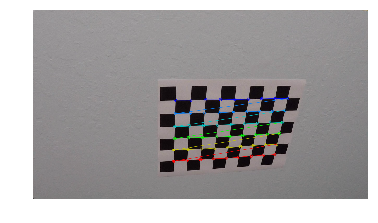

In [3]:
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

is_image_saved=False
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        if not is_image_saved:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            save_img("ChessboarCorners",img)
            plt.imshow(img)
            plt.axis('off')
            is_image_saved=True
    else:
        print("Corners not found in the " + fname )      


## Distorsion coefficients

array([[[ 97, 153, 200],
        [ 96, 154, 200],
        [ 96, 154, 200],
        ..., 
        [ 87, 149, 196],
        [ 86, 148, 195],
        [ 85, 147, 194]],

       [[ 97, 153, 200],
        [ 97, 153, 200],
        [ 97, 153, 200],
        ..., 
        [ 87, 149, 196],
        [ 85, 147, 194],
        [ 85, 147, 194]],

       [[ 98, 154, 201],
        [ 98, 154, 201],
        [ 97, 153, 200],
        ..., 
        [ 86, 148, 195],
        [ 86, 148, 195],
        [ 86, 148, 195]],

       ..., 
       [[105,  91, 104],
        [104,  90, 103],
        [105,  91, 103],
        ..., 
        [125, 106,  99],
        [123, 104,  97],
        [121, 102,  95]],

       [[109,  94, 105],
        [109,  94, 105],
        [109,  94, 105],
        ..., 
        [126, 107, 100],
        [125, 106,  99],
        [124, 105,  98]],

       [[112,  95, 106],
        [111,  95, 105],
        [111,  94, 103],
        ..., 
        [126, 108, 101],
        [127, 109, 102],
        [127, 109,

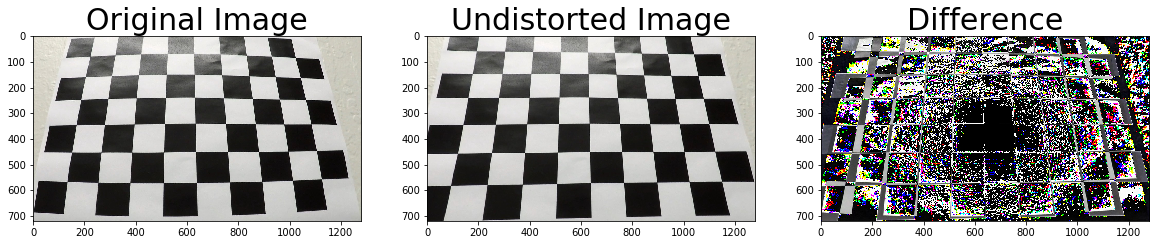

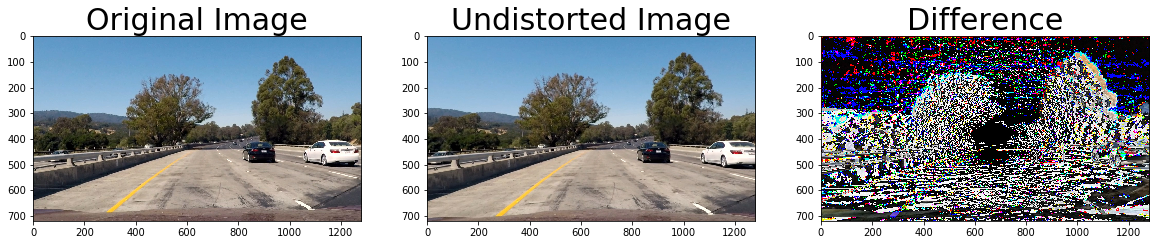

In [4]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

def undistort_image(img,name='', save_doc_image=False):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    if save_doc_image:
        save_img(name +"_distortion_original",img)
        save_img(name +"_distortion_Fixed",dst)
        save_img(name +"_distortion_Diff",dst-img)

    # Visualize undistortion
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
        ax3.imshow(dst-img)
        ax3.set_title('Difference', fontsize=30)
    return dst


img = mpimg.imread('./camera_cal/calibration3.jpg')
undistort_image(img,"calibration",True)

# Test undistortion on an image
img = mpimg.imread('./test_images/test1.jpg')
undistort_image(img,"test_image",True)

## Color filtering

Text(0.5,1,'White mask')

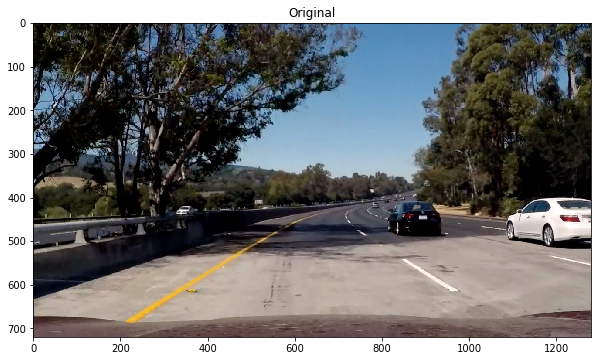

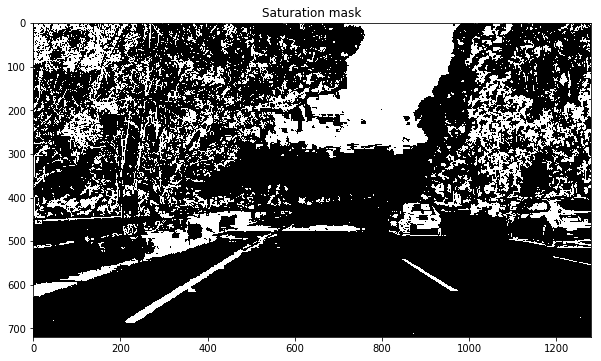

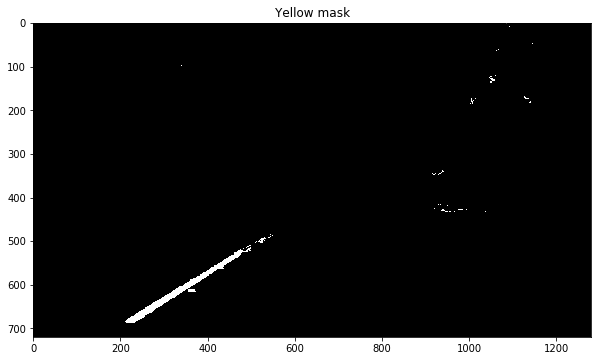

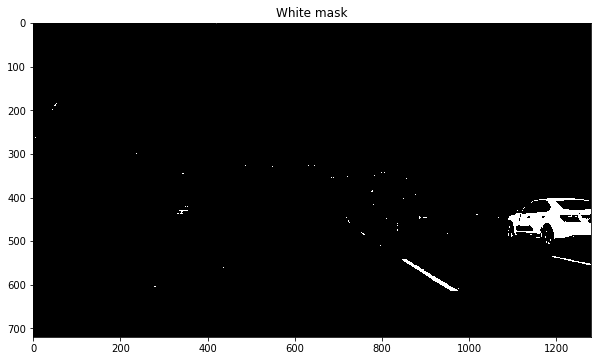

In [5]:
def mask_img(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def mask_to_rgb(img):
    return 255 * np.dstack((img, img, img))

#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

def get_yellow_treshold(img_hls):
    yellow_lower = np.array([15,50,100])
    yellow_upper = np.array([25,200,255])
    return cv2.inRange(img_hls, yellow_lower, yellow_upper) // 255
    
def get_white_threshold(img_hls):
    white_lower = np.array([0,  200, 0])
    white_upper = np.array([255,255, 255])
    return cv2.inRange(img_hls, white_lower, white_upper) // 255

def get_saturation_mask(img, thresh=(100,255)):
    # Convert to HLS
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Create saturation mask
    s_mask = mask_img(img_hls[:,:,2], thresh)
    
    return s_mask

plt.rcParams['figure.figsize'] = (10.0, 10.0)

test_img = './test_images/test5.jpg'
img = mpimg.imread(test_img)
plt.figure()
plt.imshow(img)
plt.title('Original')
plt.figure()

saturation_mask = get_saturation_mask(img, thresh = (100,255))
plt.imshow(saturation_mask, cmap='gray')
plt.title('Saturation mask')

yellow_mask = get_yellow_treshold(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
plt.figure()
plt.imshow(yellow_mask, cmap='gray')
plt.title('Yellow mask')

white_mask = get_white_threshold(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
plt.figure()
plt.imshow(white_mask, cmap='gray')
plt.title('White mask')

## Gradient filtering

In [6]:
def calculate_sobel(img,orient):
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise NotImplemented
    
    return sobel

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    abs_sobel = np.absolute(calculate_sobel(img,orient))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    return  mask_img(scaled_sobel, thresh)

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    sobelx = calculate_sobel(img,orient="x")
    sobely = calculate_sobel(img,orient="y")
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    return  mask_img(gradmag, thresh)

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    sobelx = calculate_sobel(img,orient="x")
    sobely = calculate_sobel(img,orient="y")
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return  mask_img(absgraddir, thresh)

Text(0.5,1,'Gradient direction')

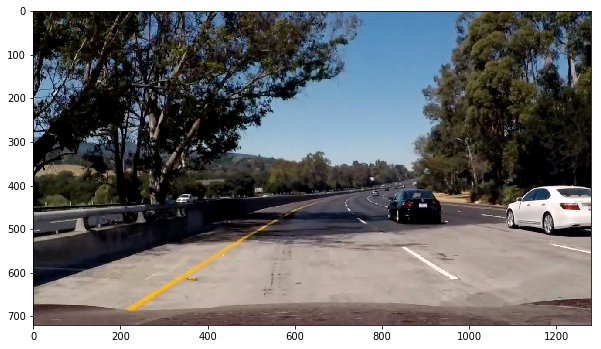

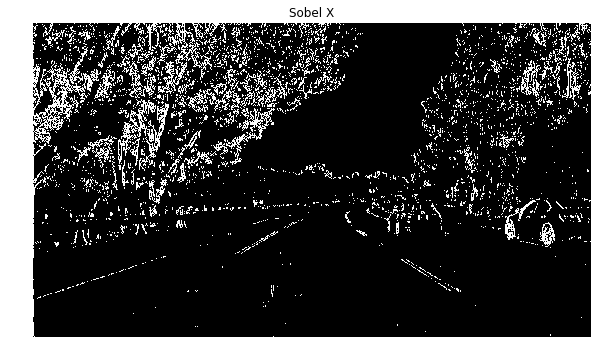

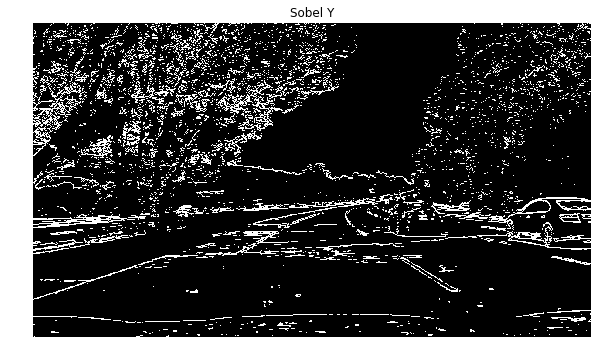

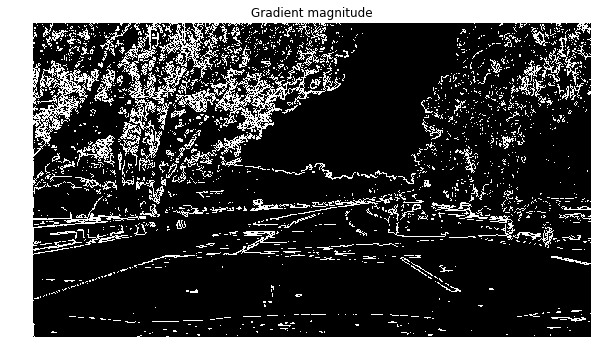

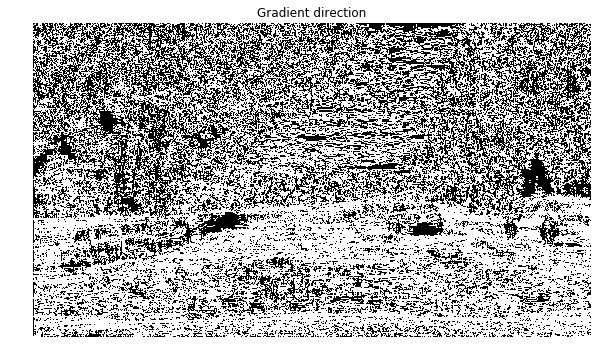

In [7]:
test_img = './test_images/test5.jpg'
img = mpimg.imread(test_img)
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(abs_sobel_thresh(img, orient = 'x', thresh=(25,255)), cmap='gray')
plt.axis('off')
plt.title('Sobel X')

plt.figure()
plt.imshow(abs_sobel_thresh(img, orient = 'y', thresh=(25,255)), cmap='gray')
plt.axis('off')
plt.title('Sobel Y')

plt.figure()
plt.imshow(mag_thresh(img, thresh=(30,100)), cmap='gray')
plt.axis('off')
plt.title('Gradient magnitude')

plt.figure()
plt.imshow(dir_threshold(img, thresh=(0.7, 2.0)), cmap='gray')
plt.axis('off')
plt.title('Gradient direction')

## Combined mask

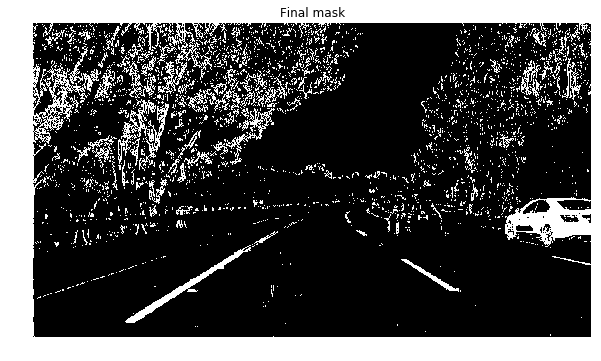

In [8]:
def combined_mask(img):
    # Color masks
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    yellow_mask = get_yellow_treshold(img_hls)
    white_mask = get_white_threshold(img_hls)
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    #Gradient
    sobel_x_mask = abs_sobel_thresh(img, orient = 'x', thresh=(25,255))
    # Result mask
    output_mask = cv2.bitwise_or(sobel_x_mask, color_mask)    
    sub_masks = [yellow_mask, white_mask, color_mask, sobel_x_mask]
    
    return output_mask, sub_masks

test_img = './test_images/test5.jpg'
img = mpimg.imread(test_img)
mask_combined,_ = combined_mask(img)
mask_combined_rgb = mask_to_rgb(mask_combined)
plt.figure()
plt.imshow(mask_combined_rgb)
plt.axis('off')
plt.title('Final mask')
save_img('final_img_mask',mask_combined_rgb)

## Perspective transformation

((200, 720), (1120, 720), (717, 470), (566, 470))
((300, 720), (1020, 720), (1020, 0), (300, 0))


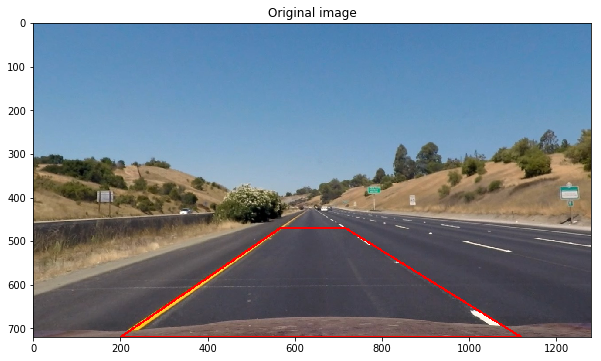

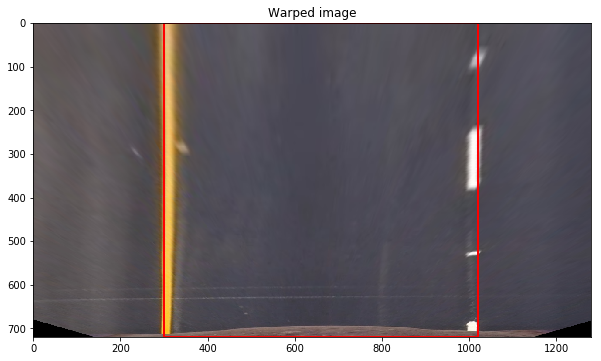

In [9]:
test_img = './test_images/straight_lines1.jpg'
img = mpimg.imread(test_img) 
img = undistort_image(img)

x1 = 200
x2 = 1120
y_horizon = 470
src_pts_ = ((x1, img.shape[0]),
            (x2, img.shape[0]),
            (717, y_horizon),
            (566, y_horizon))

off = 100 # Horizontal offset to have more space and better estimate sharp curves
dst_pts_ = ((x1 + off, img.shape[0]),
            (x2 - off, img.shape[0]),
            (x2 - off, 0),
            (x1 + off, 0))  

print(src_pts_)
print(dst_pts_)

def get_birds_eye_view(img, src_pts=src_pts_, dst_pts=dst_pts_):
    img_size = (img.shape[1], img.shape[0])    
   
    M    = cv2.getPerspectiveTransform(np.float32(src_pts), np.float32(dst_pts))
    Minv = cv2.getPerspectiveTransform(np.float32(dst_pts), np.float32(src_pts))

    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR), M, Minv


img_pts = img.copy()
for i in range(4):
    img_pts = cv2.line(img_pts, src_pts_[i], src_pts_[(i+1)%4], color=[255,0,0], thickness=4)
    
    
img_warped,_,_ = get_birds_eye_view(img)
for i in range(4):
    img_warped_pts = cv2.line(img_warped, dst_pts_[i], dst_pts_[(i+1)%4], color=[255,0,0], thickness=4)
    
plt.figure()
plt.imshow(img_pts)
plt.title('Original image')
save_img('persp_transform_original',img_pts)

plt.figure()
plt.imshow(img_warped_pts)
plt.title('Warped image')
save_img('persp_transform_warped',img_warped_pts)

## Lane base point search

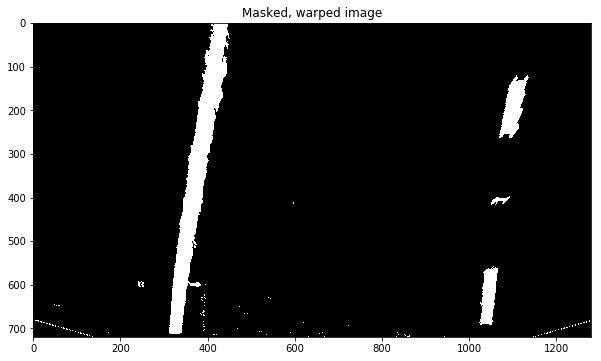

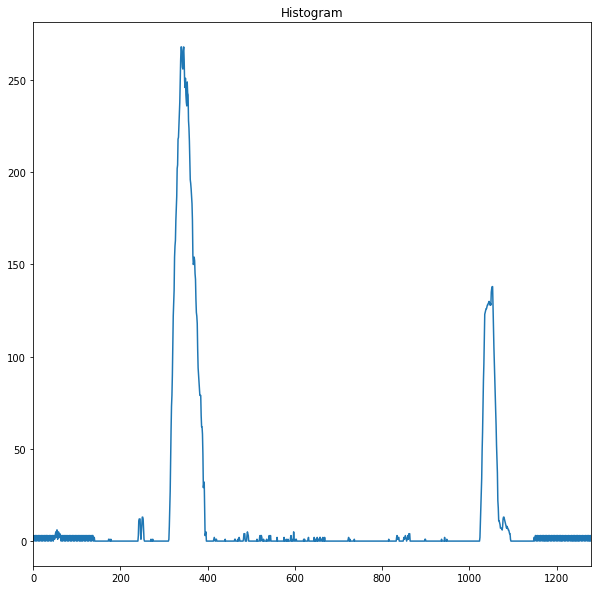

In [10]:
test_img = './test_images/test3.jpg'
img_original = mpimg.imread(test_img) 
img = undistort_image(img_original)
img_warped, M, Minv = get_birds_eye_view(img)
img_mask,_ = combined_mask(img_warped)

def get_base_x(img, visualize=False):
    # Compute histogram
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    if visualize:
        plt.plot(histogram);
        plt.autoscale(enable=True, axis='x', tight=True);
        plt.title("Histogram")
        
    # Get left and right peaks. Assuming that left and right
    # lines will be on the left or right half of the image

    x_half = int(len(histogram)/2)
    x0_left  = np.argmax(histogram[0:x_half])
    x0_right = x_half + np.argmax(histogram[x_half:])
    
    return x0_left, x0_right

plt.figure()
plt.imshow(img_mask, cmap='gray')
plt.title('Masked, warped image')
plt.figure()
x0_left, x0_right = get_base_x(img_mask, visualize = True)

# print('Left line at x = %d, right line at x = %d' % (x0_left, x0_right))

save_img('before_line_search',mask_to_rgb(img_mask))

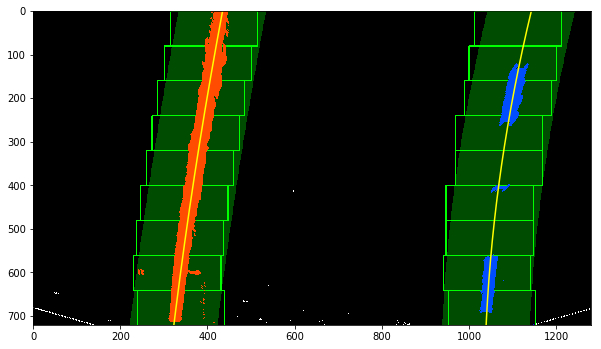

In [11]:
binary_warped = np.array(img_mask)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

leftx_base = x0_left
rightx_base = x0_right

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


save_img('after_line_search',result)

## Line tracking algorithm (splited in classes)

In [12]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

class Lane:
    def __init__(self, img, mean_left, mean_right):
        self.image=img
        self.line_left = Line()
        self.line_right = Line()
        self.line_left_coeff_mean=mean_left
        self.line_right_coeff_mean=mean_right
    
    def get_base_x(self):
        # Compute histogram
        img= self.image
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        
        x_half = int(len(histogram)/2)
        x_base_left  = np.argmax(histogram[0:x_half])
        x_base_right = x_half + np.argmax(histogram[x_half:])
        
        return x_base_left, x_base_right
    
    def get_mean_coeff(self, coeff, type='r'):
        if(type=='r'):
            return  self.get_mean_coeff_right(coeff)

        return  self.get_mean_coeff_left(coeff)

    def get_mean_coeff_left(self, coeff):
        isFound = True

        if(len(self.line_left_coeff_mean)==0):
            return coeff, isFound

        x= [self.line_left_coeff_mean,coeff]
        diff = np.diff(x,axis=0)

        diff=diff[0]
        if(abs(diff[0]) > 1 or abs(diff[1]) > 1 ):
            return self.line_left_coeff_mean, False

        return np.mean(x, axis=0), isFound
    
    def get_mean_coeff_right(self, coeff):
        isFound = True
        
        if(len(self.line_right_coeff_mean)==0):
            return coeff, isFound
        x= [self.line_right_coeff_mean,coeff]
        diff = np.diff(x,axis=0)
        # if(np.isscalar(diff)==True):
        #     return coeff
        diff=diff[0]
        if(abs(diff[0]) > 1 or abs(diff[1]) > 1 ):
            return self.line_right_coeff_mean, False

        return np.mean(x, axis=0), isFound


    def find_lines(self, isBaseFound=False):
        binary_warped = self.image #np.array(img)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        leftx_base, rightx_base = self.get_base_x()

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        if(isBaseFound==False):
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            # Concatenate the arrays of indices
        else:    
            left_fit = self.line_left_coeff_mean
            right_fit = self.line_right_coeff_mean

            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        mean_left_fit, is_left_found = self.get_mean_coeff(left_fit,type='l')
        mean_right_fit, is_right_found = self.get_mean_coeff(right_fit,type='r')

        left_fit = mean_left_fit
        right_fit = mean_right_fit

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #Curvature
        y_eval = np.max(binary_warped.shape[0])
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        curvature = (left_curverad + right_curverad)/2
        #print(curvature, 'm')

        half_picture=(rightx_base - leftx_base)/2 
        right_base_pos= abs(((half_picture - binary_warped.shape[1]/2) * xm_per_pix)) - 1.5

        #print("Left:",  left_base_pos, 'm',  "Right:",right_base_pos[0], 'm')
        #print("Left:",  left_fit,  "Right:",right_fit)
        self.line_left.allx=leftx
        self.line_left.ally=lefty
        self.line_left.line_base_pos=leftx_base
        self.line_left.current_fit = left_fit
        self.line_left.radius_of_curvature = curvature
        self.line_left.line_base_pos = right_base_pos
        self.line_left.detected= is_left_found

        self.line_right.allx=rightx
        self.line_right.ally=righty
        self.line_right.line_base_pos=rightx_base
        self.line_right.current_fit = right_fit
        self.line_right.radius_of_curvature = curvature
        self.line_right.line_base_pos = right_base_pos
        self.line_right.detected= is_right_found

        return ploty , left_fitx, right_fitx

class LanePipeline:
    def __init__(self):
        self.average_number=10
        self.lanes_left = []
        self.lanes_right= []
        self.mean_left=[]
        self.mean_right=[]
        self.isFound=False
    def returnLaneLeftCoefficient(self, coeff):
        self.lanes_left.append(coeff)

        if(len(self.lanes_left) >= self.average_number):
            np.delete(self.lanes_left, 1, 0)

        return np.mean(self.lanes_left, axis=0)

    def returnLaneRightCoefficient(self, coeff):
        self.lanes_right.append(coeff)

        if(len(self.lanes_right) >= self.average_number):
            np.delete(self.lanes_right, 1, 0)

        return np.mean(self.lanes_right, axis=0)

    def execute(self,img):
        undist = undistort_image(img)

        warped_img, M, Minv = get_birds_eye_view(undist)

        binary_warped, filter_images  = combined_mask(warped_img)

        lane= Lane(binary_warped, self.mean_left,self.mean_right)
        ploty, left_fitx, right_fitx = lane.find_lines(self.isFound)

        self.isFound = lane.line_left.detected
        self.mean_left =  self.returnLaneLeftCoefficient(lane.line_left.current_fit)
        self.mean_right = self.returnLaneRightCoefficient(lane.line_right.current_fit)
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.putText(undist,"Road curvature:%.1f m" % lane.line_left.radius_of_curvature,(100,50),cv2.FONT_HERSHEY_SIMPLEX,2,(255, 255, 255),2)
        cv2.putText(undist,"Distance:%.1f m" % lane.line_left.line_base_pos,(100,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255, 255, 255),2)
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
       
        return result

## Testing pipeline on images

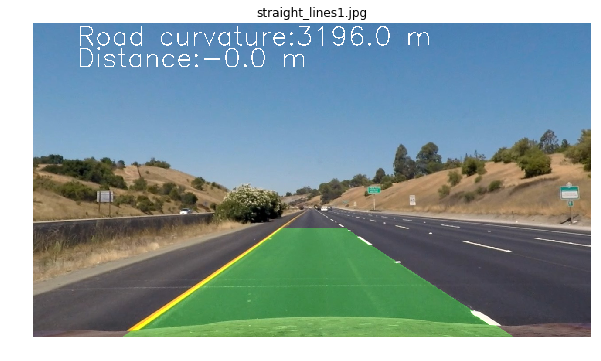

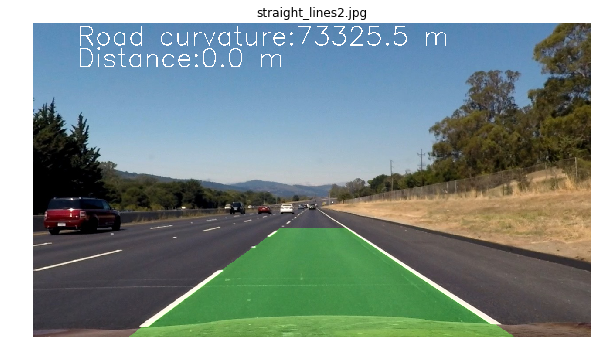

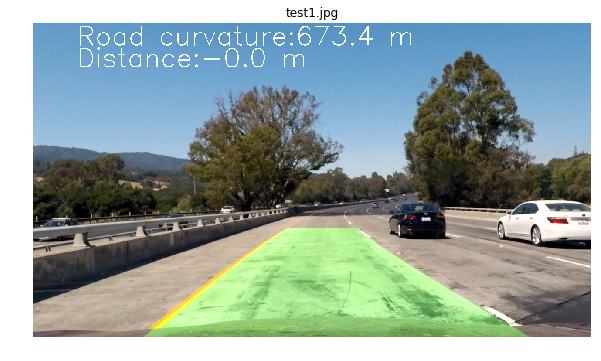

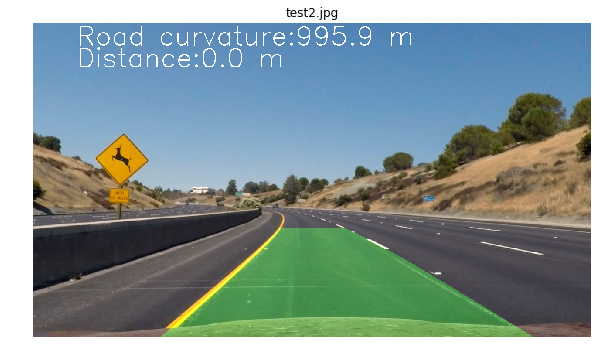

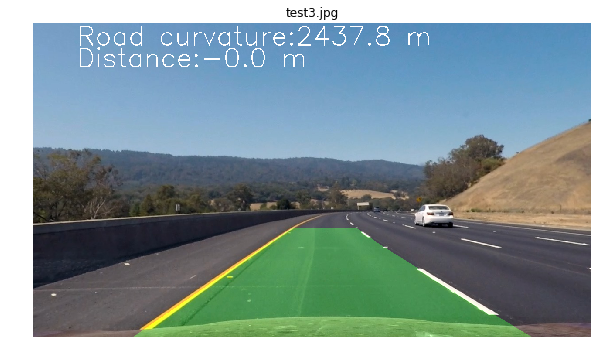

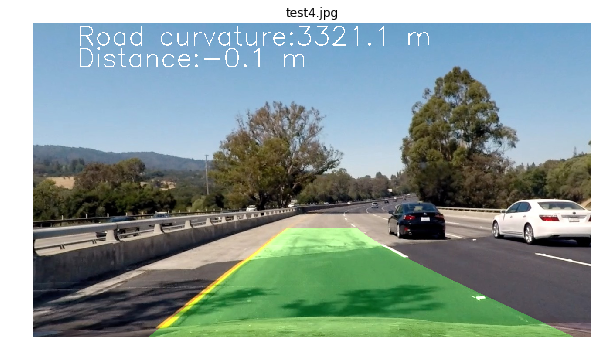

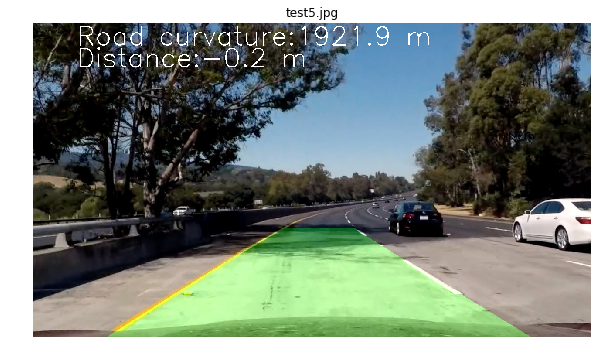

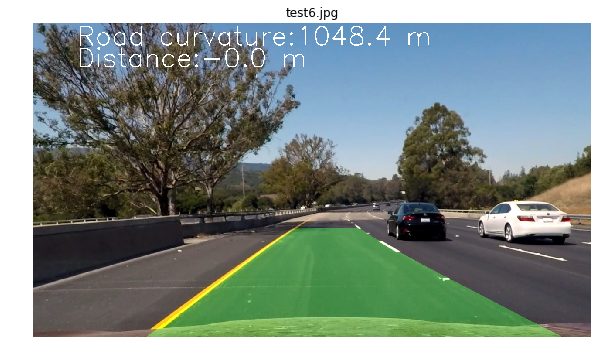

In [13]:
test_images = glob.glob('./test_images/*.jpg')

for img_path in test_images:
    _,img_name = os.path.split(img_path)
    
    pipeline = LanePipeline()
    
    # Read image
    img = mpimg.imread(img_path)
    
    # Run it on the image
    img_out = pipeline.execute(img)

    save_img(img_name,img_out)
    
    # Display
    plt.figure();
    plt.imshow(img_out); 
    plt.axis('off');
    plt.title(img_name);

## Testing pipeline on videos

In [14]:
def show_on_vide(video):
    pipeline = LanePipeline()
    
    # Read video
    clip = VideoFileClip(video)
    
    # Process video
    clip_processed = clip.fl_image(pipeline.execute)
    
    # Save to disk
    _,video_name = os.path.split(video)
    out_name = os.path.join(output_images_dir, video_name)
    clip_processed.write_videofile(out_name, audio=False)
    
    # Display in the notebook
    print(out_name)
    display(HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(out_name)))


video= os.path.join(os.getcwd(), 'challenge_video.mp4')
show_on_vide(video)

video= os.path.join(os.getcwd(), 'project_video.mp4')
show_on_vide(video)






   

[MoviePy] >>>> Building video ./output_images\challenge_video.mp4
[MoviePy] Writing video ./output_images\challenge_video.mp4


100%|███████████████████████████████████████████████| 485/485 [01:28<00:00,  6.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images\challenge_video.mp4 

./output_images\challenge_video.mp4


[MoviePy] >>>> Building video ./output_images\project_video.mp4
[MoviePy] Writing video ./output_images\project_video.mp4


100%|████████████████████████████████████████████▉| 1260/1261 [03:49<00:00,  6.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images\project_video.mp4 

./output_images\project_video.mp4
